# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)

### Assignments

3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from matplotlib.ticker import MultipleLocator as mpl
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
import pandas_bokeh
from bokeh.models import CrosshairTool
from bokeh.models import HoverTool

pandas_bokeh.output_notebook()
%matplotlib inline
#%precision 4

Loading BokehJS ...

In [2]:
#load the file
file_name = r"C:\Users\utente\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu18.04onWindows_79rhkp1fndgsc\LocalState\rootfs\home\beppe\Earthquake-Data-Analysis\SouthCalifornia-1982-2011_Physics-of-Data.dat"
df = pd.read_csv(file_name, sep='\s', usecols=[i for i in range(0,7,1)], 
                 names=['index','pointer','t','mag','x','y','z'], engine='python')

#convert the seconds in standard form time
#df['t'] = pd.to_datetime(df['t'], unit='s').astype('datetime64[s]')
df.sort_values(by='t')
T = 40
Tmax = 10**6
c=60*60*24

Text(0, 0.5, 'N')

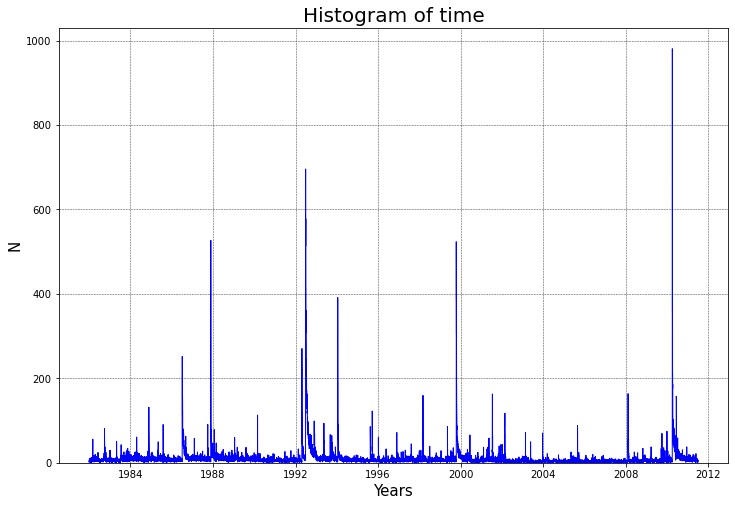

In [3]:
plt.figure(figsize=(12,8))
df['date'] = pd.to_datetime(df['t'], unit='s', origin='01/01/1982')
N = len(df['date'])

n, bins, patches = plt.hist(df['date'], histtype='step', bins=29*365, color='b')
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
#plt.clf()
#plt.scatter(binscenters, n, color='r', label='Bins position', zorder=3)
#plt.plot(binscenters, n, color='r', linestyle='--', alpha=0.8, zorder=2)
plt.grid(True, linestyle="--", linewidth=0.5, color='.25')
plt.title('Histogram of time', fontsize=20)
plt.xlabel('Years', fontsize=15)
plt.ylabel('N', fontsize=15)

## ANALYSIS OF DISTRIBUTION P(t)

In [4]:
def fit_pdf(x, K, p):
    return K*((x)**(-p))

def fit_pdf2(x, K, c):
    return K*((x+c)**(-1))

def fit_pdf3(x, K, c, p):
    return K*((x+abs(c))**(-p))

In [5]:
#slider of histogram of waiting time
from scipy import stats

def histo(m, nbins):
    plt.figure(figsize=(12,7))
    mask = df['mag'] >= m
    dt = df['t'][mask].diff().dropna(how='any')
    dt = dt[dt > T]
    dt = dt[dt < Tmax]
    
    #histogram of waiting time
    n, bins, patches = plt.hist(dt, bins = np.logspace(np.log10(dt.min()), np.log10(dt.max()), nbins), alpha = 0.4, color = 'r', 
                                edgecolor='b', label = 'Data distribution', density=True, linewidth=1, 
                                zorder=1, visible=0)
    plt.close('all')
    
    Y = n[n>0]
    X = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    X = X[n>0]
    
    #fit model 1
    par, pcov = curve_fit(fit_pdf, xdata=X, ydata=Y, p0=[0.01, 1])
    perr = np.sqrt(pcov)
    
    #fit model 2
    par2, pcov2 = curve_fit(fit_pdf2, xdata=X, ydata=Y, p0=[0.1, 0])
    perr2 = np.sqrt(pcov2)
    
    #fit model 3
    par3, pcov3 = curve_fit(fit_pdf3, xdata=X, ydata=Y, p0=[0.01, 0, 1])
    perr3 = np.sqrt(abs(pcov3))
    
    #results
    print('MAGNITUDE ABOVE m=' + str(m))
    print('---Fit Parameters model 1---')
    print('K= %0.2f +/- %0.2f' %(par[0], perr[0][0]))
    print('p= %0.2f +/- %0.2f' %(par[1], perr[1][1]))
    
    print('---Fit Parameters model 2---')
    print('K= %0.3f +/- %0.3f' %(par2[0], perr2[0][0]))
    print('c= %0.0f +/- %0.0f' %(abs(par2[1]), perr2[1][1]))
    
    print('---Fit Parameters model 3---')
    print('K= %0.2f +/- %0.2f' %(par3[0], perr3[0][0]))
    print('c= %0.0f +/- %0.0f' %(abs(par3[1]), perr3[1][1]))
    print('p= %0.2f +/- %0.2f' %(par3[2], perr3[2][2]))
    
    print('---Compatibiliy between p and expected value (p = 1)---')
    lam_p1 = np.abs(par[1]-1)/(perr[1][1])**0.5
    print('lambda with p from model 1 = %0.2f' %lam_p1)
    lam_p3 = np.abs(par3[2]-1)/(perr3[2][2])**0.5
    print('lambda with p from model 3 = %0.2f\n' %lam_p3)

    return X, Y, [par, par2, par3]

In [9]:
from bokeh.plotting import figure, output_file, show
x2, y2, pfit2 = histo(2,30)
x3, y3, pfit3 = histo(3,30)
x4, y4, pfit4 = histo(4,30)
x5, y5, pfit5 = histo(5,30)

dw = pd.DataFrame(list(zip(y2,y3,y4,y5)), columns = ['m=2', 'm=3', 'm=4', 'm=5'])

p = figure(x_axis_type='log', y_axis_type='log', plot_width=800, plot_height=600, title="Histogram of Waiting times")

#histograms
p.scatter(x = x2, y=y2, color="blue", legend_label='m=2', marker='circle', size=7, alpha=0.75)
p.scatter(x = x3, y=y3, color="orange", legend_label='m=3', marker='square', size=7,)
p.scatter(x = x4, y=y4, color="green", legend_label='m=4', marker='triangle', size=7)
p.scatter(x = x5, y=y5, color="red", legend_label='m=5', marker='*', size=7)

#fit plot
p.line(x=np.linspace(50, 3*10**4,100), y=fit_pdf3(np.linspace(50, 3*10**4,100), *pfit2[2]), color="blue", legend_label='f3(m=2)', 
       line_width=1.5)
p.line(x=np.linspace(50, 10**6,100), y=fit_pdf3(np.linspace(50, 10**6,100), *pfit3[2]), color="orange", legend_label='f3(m=3)', 
       line_width=1.5)
p.line(x=np.linspace(50, 10**6,100), y=fit_pdf(np.linspace(50, 10**6,100), *pfit4[0]), color="green", legend_label='f1(m=4)', 
       line_width=1.5)
p.line(x=np.linspace(50, 10**6,100), y=fit_pdf(np.linspace(50, 10**6,100), *pfit5[0]), color="red", legend_label='f1(m=5)', 
       line_width=1.5)

p.legend.click_policy='hide'
p.legend.location='top_right'
p.xaxis.axis_label = 'Waiting times (s)'
p.yaxis.axis_label = 'P_{m} (t)'
show(p)

MAGNITUDE ABOVE m=2
---Fit Parameters model 1---
K= 0.01 +/- 0.00
p= 0.60 +/- 0.02
---Fit Parameters model 2---
K= 0.162 +/- 0.004
c= 107 +/- 5
---Fit Parameters model 3---
K= 0.17 +/- 0.07
c= 109 +/- 17
p= 1.01 +/- 0.06
---Compatibiliy between p and expected value (p = 1)---
lambda with p from model 1 = 2.54
lambda with p from model 3 = 0.03

MAGNITUDE ABOVE m=3
---Fit Parameters model 1---
K= 0.01 +/- 0.00
p= 0.70 +/- 0.03
---Fit Parameters model 2---
K= 0.095 +/- 0.003
c= 59 +/- 4
---Fit Parameters model 3---
K= 0.29 +/- 0.14
c= 92 +/- 15
p= 1.17 +/- 0.07
---Compatibiliy between p and expected value (p = 1)---
lambda with p from model 1 = 1.85
lambda with p from model 3 = 0.64

MAGNITUDE ABOVE m=4
---Fit Parameters model 1---
K= 0.04 +/- 0.01
p= 0.93 +/- 0.07
---Fit Parameters model 2---
K= 0.056 +/- 0.006
c= 3 +/- 7
---Fit Parameters model 3---
K= 0.02 +/- 0.01
c= 0 +/- 11
p= 0.80 +/- 0.10
---Compatibiliy between p and expected value (p = 1)---
lambda with p from model 1 = 0.26
lam

-  When examining waiting times we lose information about the real time of each event, which can be regarded as a disadvantage, this, however, depends on which relations we consider most interesting 

-  real data series include a complex series of foreshocks, main shocks and aftershocks, and just which events are main shocks may be difficult to define

-  it is important to also analyse lthe data in order to try to identify underlying patterns of behaviour

- Observing empirical waiting time probability distributions demonstrate a characteristic pattern, with power law behaviour at short and intermediate waiting times, and a marked decrease in the number of events at larger waiting times

- It has been claimed that the observed characteristic pattern reflects important physics of the system related to a change in event correlation which scales in a defined manner with changes in threshold magnitude, waiting time and spatial distance

- In our analysis we calculate the waiting times between time-neighbouring events and make a histogram of the count using successive bins that are logarithmically increasing in length. Such count histograms are equivalent to the statistical probability distributions, this can illuminate more details of the data on the graphs than can the corresponding probability density functions (p.d.f.)

- It is relevant to recall that the Omori law is a purely empirical law without any complete underlying physical theory. It is therefore likely that it is, on a fundamental level, only an approximation to the seismological reality

- (In the waiting time domain the inverse of the rate at t=C can be considered as point where the short waiting time asymptote ends)

- aftershocks don’t all occur instantly at the time of the mainshock, but they have a time dependence that is described by Omori’s law

Model 1: $P_m (t) = \frac{K}{t^p}$ \
\
Model 2: $P_m (t) = \frac{K}{t + c}$ \
\
Model 3: $P_m (t) = \frac{K}{(t+c)^p}$ 

Model 3 parameters: 

m | b| K| c| p 
---|---|-----|-----|-----
2|30|0.15 +/- 0.06|103 +/- 18|0.99 +/- 0.06
3|30|0.14 +/- 0.03|67 +/- 7|1.07 +/- 0.04
4|30|0.11 +/- 0.08|42 +/- 23|1.04 +/- 0.12
5|30|1016 +/- 14786|367 +/- 502|2.28 +/- 1.98

## ANALYSIS OF ONE SINGLE POINTER VALUE

In [7]:
#slider of histogram of waiting time of specific events
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def histo2(m, b, eve, c, ed):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
    fig.suptitle('Histograms of Waiting time of specific events', fontsize=25)
    
    #df['event'] = df['pointer'].where(df['pointer'] != -1, df['index'])
    df_g = df[df['pointer'] == eve]
    mask = df_g['mag'] >= m
    dt = df_g['t'][mask].diff().dropna(how='any')
    dt = dt[dt > T]
    #print('Description of all event set:\n', df['event'].describe(), '\n')
    #print('Description of this event set:\n', dt.describe())
    
    #histogram of waiting time
    n, bins, patches = ax1.hist(dt, bins = np.logspace(np.log10(dt.min()), np.log10(dt.max()), b), alpha = 0.5, 
             color = c, edgecolor=ed, label = 'Data distribution', density=True)
    
    Y = n[n>0]
    X = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    X = X[n>0]
    
    ax1.scatter(X, Y, color='r', label='Bins position', zorder=3)
    
    t = np.linspace(X.min(), X.max(),100)
    #fit model 1
    par, pcov = curve_fit(fit_pdf, xdata=X, ydata=Y, p0=[0.01, 1])
    perr = np.sqrt(abs(pcov))
    ax1.plot(t, fit_pdf(t, *par), color='b', linewidth=2, label='Model 1')
    res = stats.linregress(X,Y)
    
    #fit model 2
    par2, pcov2 = curve_fit(fit_pdf2, xdata=X, ydata=Y, p0=[0.1, 0])
    perr2 = np.sqrt(pcov2)
    ax1.plot(t, fit_pdf2(t, *par2), color='darkorange', linewidth=2, label='Model 2')
    
    #fit model 3
    par3, pcov3 = curve_fit(fit_pdf3, xdata=X, ydata=Y, p0=[0.01, 0, 1])
    perr3 = np.sqrt(pcov3)
    ax1.plot(t, fit_pdf3(t, *par3), color='black', linewidth=2, label='Model 3')
    
    #results
    print('---Fit Parameters model 1---')
    print('K= %0.2f +/- %0.2f' %(par[0], perr[0][0]))
    print('p= %0.2f +/- %0.2f' %(par[1], perr[1][1]))
    print('r= %0.4f' %(res.rvalue))
    print('Chi-squared model 1: %0.5f\n' %(stats.chisquare(Y,fit_pdf(X, *par))[0]))
    
    print('---Fit Parameters model 2---')
    print('K= %0.3f +/- %0.3f' %(par2[0], perr2[0][0]))
    print('c= %0.0f +/- %0.0f' %(abs(par2[1]), perr2[1][1]))
    print('Chi-squared model 2: %0.5f\n' %(stats.chisquare(Y,fit_pdf2(X, *par2))[0]))
    
    print('---Fit Parameters model 3---')
    print('K= %0.2f +/- %0.2f' %(par3[0], perr3[0][0]))
    print('c= %0.0f +/- %0.0f' %(abs(par3[1]), perr3[1][1]))
    print('p= %0.2f +/- %0.2f' %(par3[2], perr3[2][2]))
    print('Chi-squared model 2: %0.5f\n' %(stats.chisquare(Y,fit_pdf3(X, *par3))[0]))
    
    print('---Compatibiliy between p and expected value (p = 1)---')
    lam_p1 = np.abs(par[1]-1)/(perr[1][1])**0.5
    print('lambda with p from model 1 = %0.2f' %lam_p1)
    lam_p3 = np.abs(par3[2]-1)/(perr3[2][2])**0.5
    print('lambda with p from model 3 = %0.2f' %lam_p3)

    print('---Compatibiliy between c and expected value (c = 0)---')
    lam_c2 = np.abs(par2[1]-1)/(perr2[1][1])**0.5
    print('lambda with c from model 2 = %0.2f' %lam_c2)
    lam_c3 = np.abs(par3[1]-1)/(perr3[1][1])**0.5
    print('lambda with c from model 3 = %0.2f' %lam_c3)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title('Histogram of Waiting times $P_{m=%0.0f}(t)$' %(m), fontsize=25)
    ax1.set_xlabel('Waiting time (s)', fontsize=15)
    ax1.set_ylabel('$log(P_{m}(t))$', fontsize=15)
    ax1.legend()

    #second plot
    ax2.scatter(X, Y, color='r', label='Bins position')
    ax2.plot(X, Y, color='b', linestyle='--', alpha=0.6)
    ax2.plot(X, fit_pdf(X, *par), color='b', linewidth=2, label='Model 1')
    ax2.plot(X, fit_pdf2(X, *par2), color='darkorange', linewidth=2, label='Model 2')
    ax2.plot(t, fit_pdf3(t, *par3), color='black', linewidth=2, label='Model 3')

    ax2.set_title('Scatter plot: ', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlabel('Waiting time (s)', fontsize=15)
    ax2.set_ylabel('Number of events', fontsize=15)
    ax2.legend()

interactive_plot = interactive(histo2, m=(2, 7, 1), b=(10,100,5), 
                               eve=widgets.IntText(description="Event", continuous_update=True), 
                               c=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'], 
                               ed=['red', 'blue', 'cyan', 'orange', 'yellow', 'green', 'black'])
output = interactive_plot.children[-1]
output.layout.height = '900px'
interactive_plot

interactive(children=(IntSlider(value=4, description='m', max=7, min=2), IntSlider(value=55, description='b', …

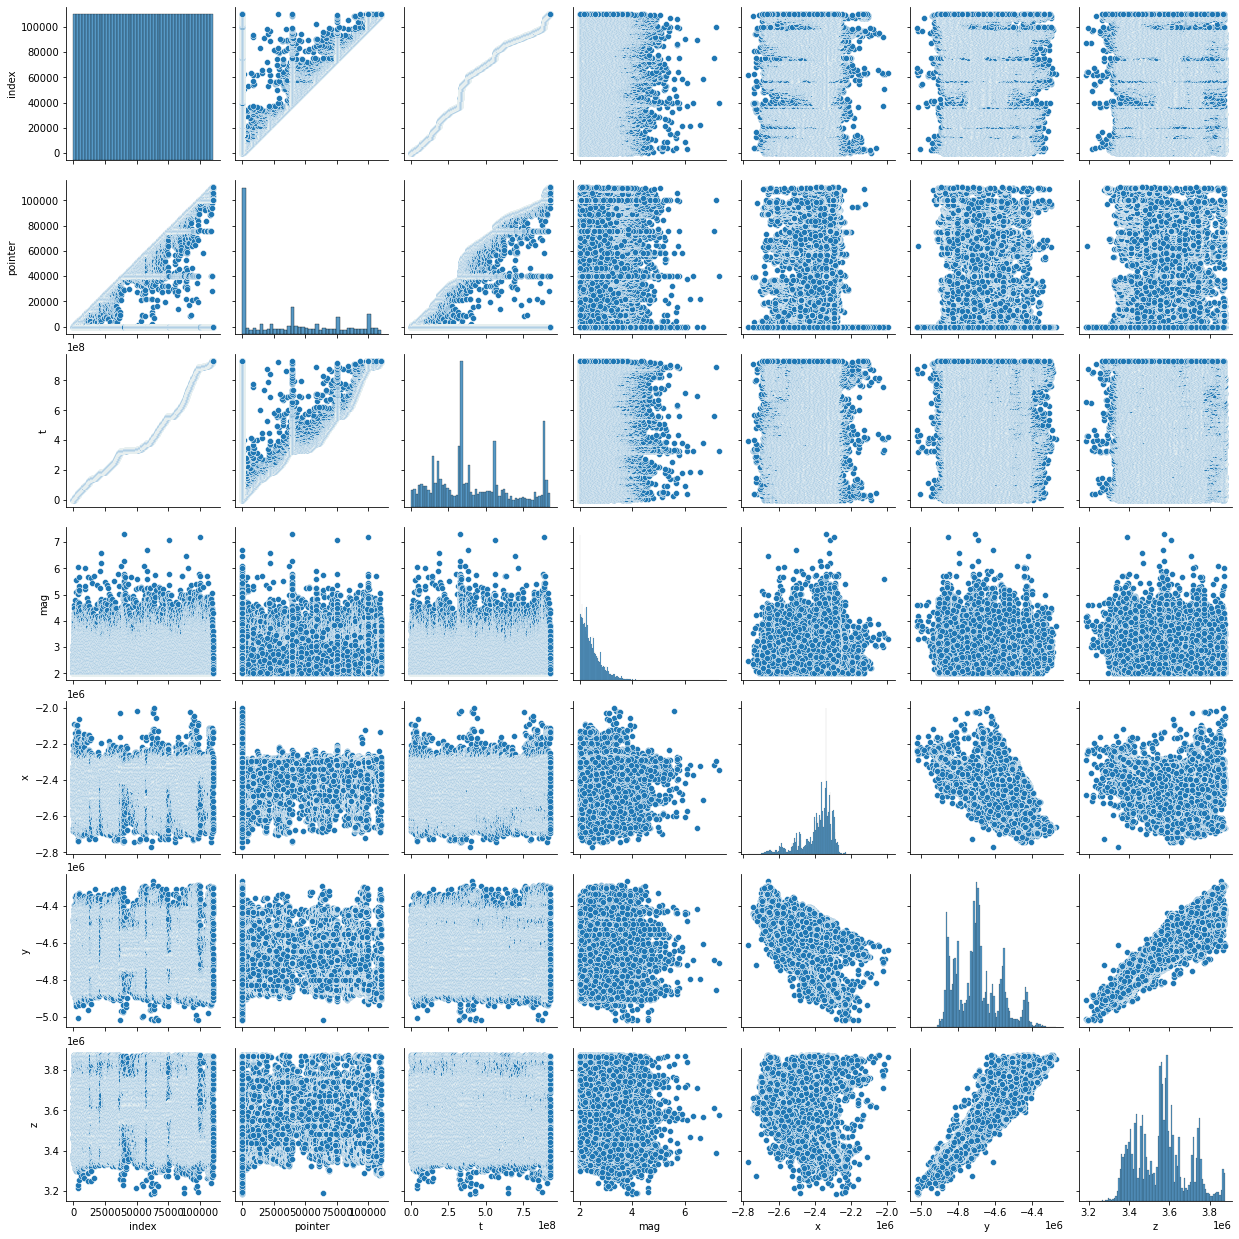

In [8]:
sns.pairplot(df)